syncmaster 710t  
- https://www.cnet.com/products/samsung-syncmaster-710t-lcd-monitor-17/
- ~~1280 x 1024 at 75 Hz~~
- (the monitor is actually running as 640x480@60fps)

Van Eck phreaking
- https://en.wikipedia.org/wiki/Van_Eck_phreaking

Paper with math
- https://raw.githubusercontent.com/martinmarinov/TempestSDR/master/documentation/acs-dissertation.pdf

### Challenge description


Signal processing: this time with real signals!

Disclaimer: might not contain actual walls.

https://storage.googleapis.com/eu-unionctf-2021/walls.tar.gz

The recording was made after running cat flag.txt; other than that, everything was the same as in the setup photo.

Author: dd


File format: interleaved I/Q samples; 32-bit little-endian floats  
Recording parameters: sampling frequency = 64 MHz (bandwidth = 40 MHz), centre frequency = 425 MHz


### Load data
convert to complex numbers

In [1]:
import struct
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pathlib

In [2]:
data = np.fromfile("ctf-425M-64M-40M.dat", dtype="float32")

In [3]:
Is = data[::2]
Qs = data[1::2]

data = data[0::2] + 1j*data[1::2]

### autocorrelation to get $y_t$

the peaks in the autocorrelation tell us how many timesteps it takes to process each row of pixels. We find that the autocorrelation has a peak every ~2029 timesteps.

cf https://raw.githubusercontent.com/martinmarinov/TempestSDR/master/documentation/acs-dissertation.pdf

Use fft-based convolution to get that linear runtime

In [4]:
"""
zero padding and stuff
so we can express autocorrelation in terms of a convolution
and then use FFT-based convolution for sp33d
"""
data_length = len(data)
b = np.zeros(data_length * 2, dtype=np.complex64)
b[data_length//2:data_length//2+data_length] = data

%time c = signal.fftconvolve(b, np.conj(b[::-1]), mode='full')

CPU times: user 10.9 s, sys: 3.91 s, total: 14.8 s
Wall time: 15.6 s


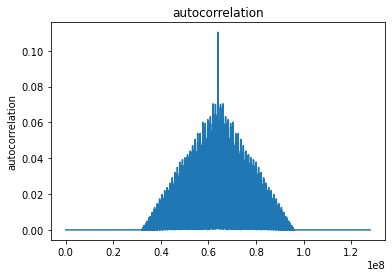

In [5]:
plt.plot(np.abs(c))
plt.title("time delay (timesteps)")
plt.ylabel("autocorrelation")
plt.title("autocorrelation")
plt.show()

In [6]:
"""
there's some zero padding, and also the autocorrelation is symmetric
Discard all that fluff.
"""
d = c[data_length*2:data_length*3]

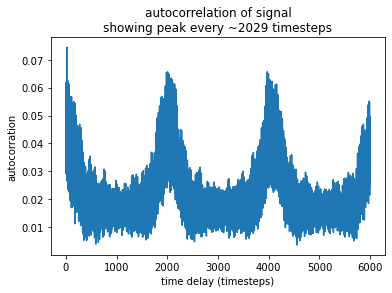

In [7]:
plt.plot(np.abs(d[:6000]))
plt.xlabel("time delay (timesteps)")
plt.ylabel("autocorration")
plt.title("autocorrelation of signal\nshowing peak every ~2029 timesteps")
plt.show()

In [8]:
"""
i get the location of the n'th peak and divide by n
to try and get a slightly more accurate estimate
"""
dt0 = 2029

n = 100
a = int((n - 0.5) * dt0)
b = int((n + 0.5) * dt0)
dt = (np.argmax(np.abs(d[a:b])) + a) / n

print(dt)

2031.73


autocorrelation peaks every ~2029 timesteps

### Display time series as a grid

because the number of timesteps it takes to process each pixel row (~2029) is only a few times larger the number of pixels in each row (640), we can get away with just plotting the raw signal in a grid.

Formally we should apply a low passband filter, but this would only be really important if we had a much higher sampling rate. We'd have to do some p fancy math if the sampling rate was lower than the number of pixels.

pixel intensity is vaguelly proportional to the absolute value of the signal, after you normalize the data

In [9]:

X = np.abs(data)
X -= np.mean(X)
X /= np.std(X)



sweep the row dimension near the 2029 timestep from the autocorrelation section. For each row dimension, plot the image into a rectangular grid.

we can use the vertical bars on the side as a reference.

We find that the timestep which makes this fully periodic is a real number between 2031 and 2032

In [10]:
pathlib.Path('./images').mkdir(exist_ok=True)

2025


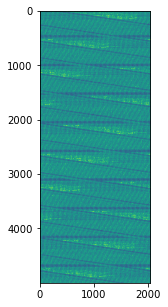

2026


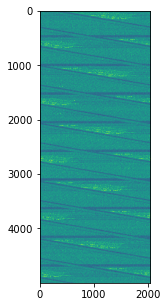

2027


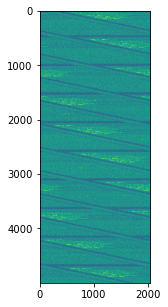

2028


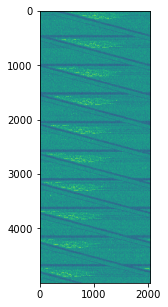

2029


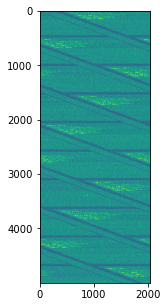

2030


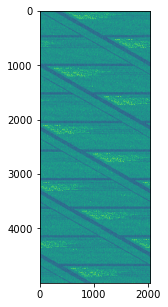

2031


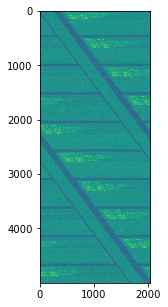

2032


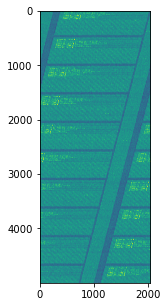

2033


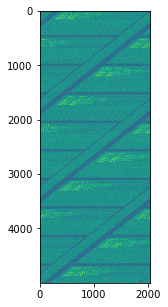

2034


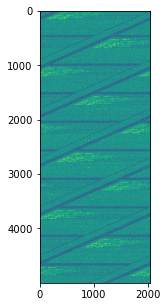

In [11]:
n = 5000
for dt in range(2025, 2035):
    Y = X[:n * dt]
    Y = Y.reshape((n, dt))
    print(dt)
    plt.figure(figsize = (5,5))
    plt.imshow(Y, vmin=-1, vmax=1)
    plt.savefig(f"images/output_{dt}.png")
    plt.show()

manually adjust the time delay until the image is really periodic

we should do some fancy math to interpolate the discrete time series at intermediate points, but instead I just round the index to the nearest integer, which works really well for this setup

I hand-optimized these parameters until the image looked good

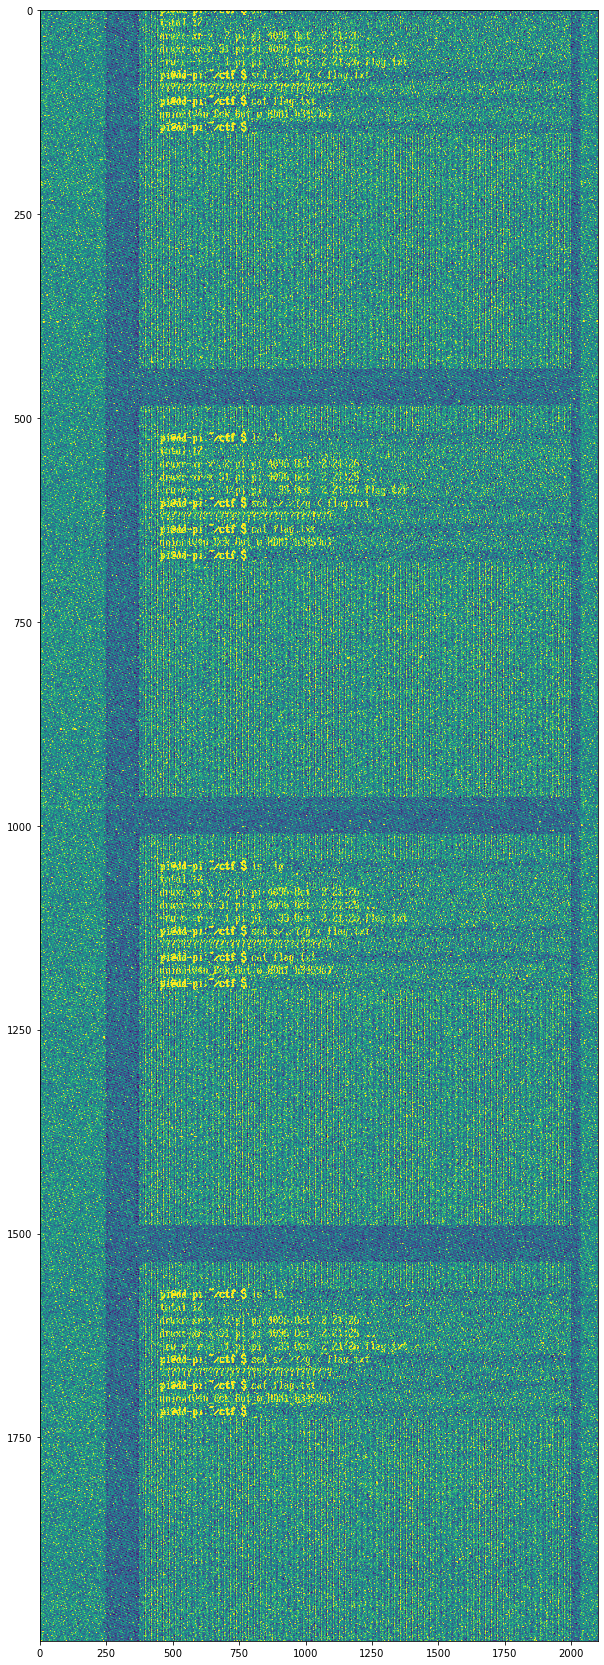

In [12]:
# number of rows
n = 2000
# timesteps per row
dt = 2031.7411333333334

# make the dst image a lil' wider
res = np.zeros((n, 2100))

for i in range(n):
    a = int(i * dt)
    b = a + 2100
    res[i] = X[a:b]


plt.figure(figsize = (10,30))
plt.imshow(res, aspect='auto', vmin=-1, vmax=1)
plt.savefig("output.png")
plt.show()

apparently, this is what you get if you just plug everything into some open source software. It clearly works, but the text is very noisy

- gr-tempest
- https://github.com/git-artes/gr-tempest

- TempestSDR
- https://github.com/martinmarinov/TempestSDR

finally, we can average out the repeated frames to get a clearer image

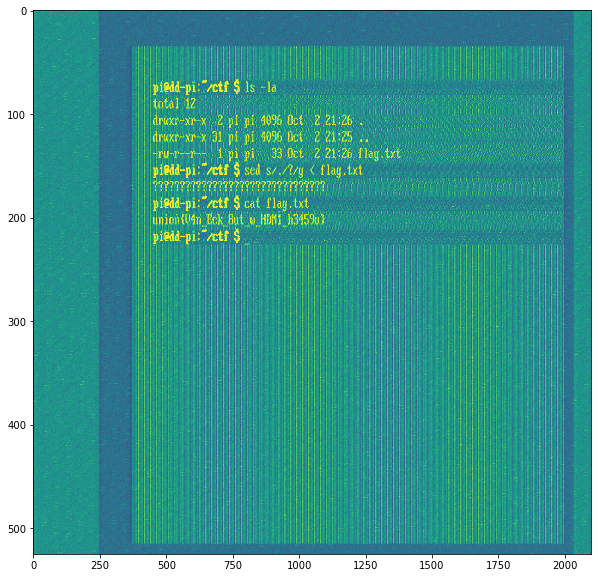

In [13]:
#number of rows
n = 15000
# skip these first few rows
n0 = 450
# timesteps per row
dt = 2031.7411333333334
# rows per image (fortunately this ended up being an exact integer, otherwise would have had to do more rounding)
m = 525

# make the dst image a lil' wider
res = np.zeros((m, 2100))

for i in range(n):
    a = int((i+n0) * dt)
    b = a + 2100
    res[i%m] += X[a:b]

res /= (n/m)

plt.figure(figsize = (10,10))
plt.imshow(res, aspect='auto', vmin=-1, vmax=1)
plt.savefig("final_output.png")
plt.show()

# Alternate solution

### fourier transform to get $y_t$ and $x_t$

the big spikes tell us how many timesteps it takes to process each row of pixels

In [14]:
"""
pixel intensity
"""
X = np.abs(data)
X -= np.mean(X)
X /= np.std(X)

fdata = np.abs(np.fft.rfft(X))

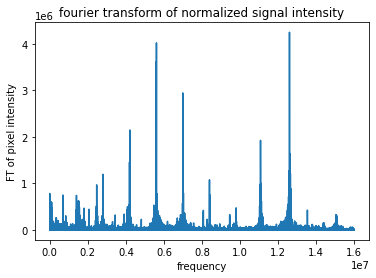

In [15]:
plt.plot(fdata)
plt.xlabel("frequency")
plt.ylabel("FT of pixel intensity")
plt.title("fourier transform of normalized signal intensity")
plt.show()

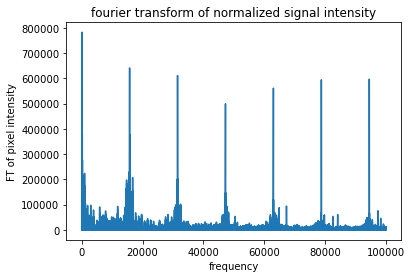

In [16]:
plt.plot(fdata[:100000])
plt.xlabel("frequency")
plt.ylabel("FT of pixel intensity")
plt.title("fourier transform of normalized signal intensity")
plt.show()

In [17]:
a = 10000
b = 20000
k0 = np.argmax(fdata[a:b]) + a
timesteps_per_pixel_row = len(data)/k0

print(k0)
print(timesteps_per_pixel_row)

15750
2031.7460317460318


this gives use our timesteps per pixel row = `2031.746`

We can again fourier transform the abs-value fourier transform, which will tell us the number of times the image as a whole is repeated in the signal. This combines with the previous info to tell us the number of pixels rows per image.

I'm not 100% sure why exactly this works

In [18]:
Y = np.abs(np.fft.rfft(fdata))

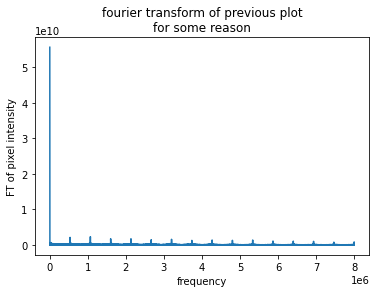

In [19]:
plt.plot(Y)
plt.xlabel("frequency")
plt.ylabel("FT of pixel intensity")
plt.title("fourier transform of previous plot\nfor some reason")
plt.show()

In [20]:
a = int(1e5)
b = int(1e6)
k1 = np.argmax(Y[a:b]) + a

print(k1)
print(len(Y)/k1)

533332
15.000039375098437


In [21]:
rows_per_image = k0 * k1 / len(fdata)

print(rows_per_image)

524.9986546875841


so each pixel row takes around `2031.746` timesteps, and we have `525` rows per image